It's time to perform AB test. The experiment took place from 2023-01-01 to 2023-01-07 inclusive, with two groups involved: Group 2 used one of the new post recommendation algorithms, while Group 1 was used as control.

The main hypothesis is that the new algorithm in Group 2 will lead to an increase in CTR.

The task is to analyze the AB test data.

Choose a method of analysis and compare the CTR in the two groups (we discussed t-test, Poisson bootstrap, Mann-Whitney test, smoothed CTR t-test (α=5), and t-test and Mann-Whitney test on bucketed data).
Compare the data using these tests:
- [x] t-test
- [x] Mann–Whitney U test
- [x] Poisson bootstrap
- [x] t-test with smoothed CTR (α=5)
- [x] t-test over bucket
- [x] Mann–Whitney over bucket
Also, visually inspect the distributions. Why did the tests perform the way they did?
Describe a potential situation in which such a change could have occurred. There is no perfect answer, so think about it.
Write a recommendation on whether to roll out the new algorithm to all new users or not.
Your solution should be a link to a merge request with the conducted analysis.

In [88]:
# import required libraries
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

In [89]:
# define connection parameters
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator_20230120'
}

In [90]:
# send the query and save the result to dataframe
q = """
SELECT user_id,
        countIf(action, action = 'view') AS views,
        countIf(action, action = 'like') AS likes,
        likes/views AS ctr,
        any(exp_group) AS exp_group
FROM simulator_20230120.feed_actions
WHERE toDate(time) >= '2023-01-01' 
AND toDate(time) <= '2023-01-07'
GROUP BY user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [91]:
df.head()

,user_id,views,likes,ctr,exp_group
0,13289,24,4,0.166667,3
1,121096,110,27,0.245455,3
2,129283,94,15,0.159574,1
3,129995,74,22,0.297297,1
4,121792,89,21,0.235955,4


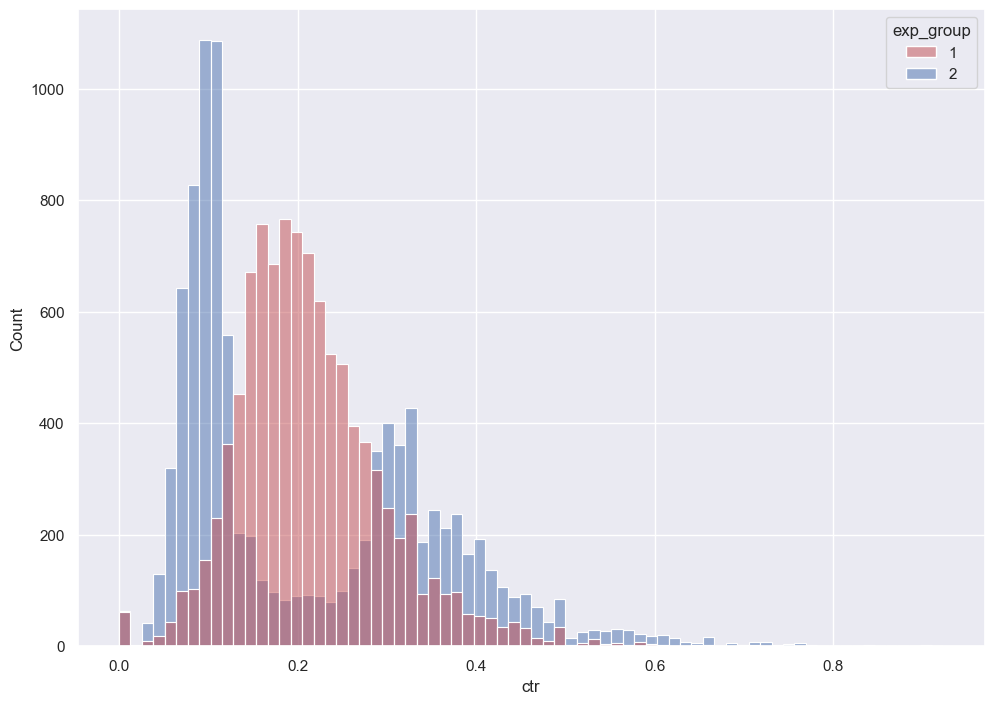

In [92]:
# checking groups distribution visually
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df.query('exp_group == 1 | exp_group == 2'), 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

**Diagram 1  🠉**  <a id='diagram_1'></a>
We can see that for experiment group 1 the distribution is unimodal, but for group two the distibution is bimodal.

# 1. T-test

In [93]:
df[df.exp_group == 1].ctr.mean()

0.21560459841296287

In [94]:
df[df.exp_group == 2].ctr.mean()

0.21441927347479375

In [95]:
stats.ttest_ind(df[df.exp_group == 1].ctr,
               df[df.exp_group == 2].ctr,
               equal_var=False)

Ttest_indResult(statistic=0.7094392041270486, pvalue=0.4780623130874935)

A p-value is more than 0.05, meaning the null hypothesis is true.   
**There is no statistically significant difference between the mean CTRs of these two groups**
___

# 2. Mann–Whitney U test

In [96]:
stats.mannwhitneyu(df[df.exp_group == 1].ctr,
                   df[df.exp_group == 2].ctr,
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

A p-value is significantly less than 0.05, meaning the null hypothesis is false; therefore, **there is a statistically significant difference between the CTR distributions of these two groups.** This fact is also confirmed visually.
___

# 3. Smoothed CTR t-test

In [97]:
# defining the smoothed ctr function

def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [98]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

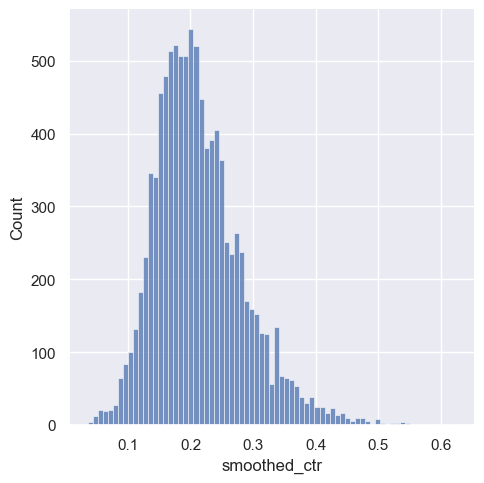

In [99]:
group1 = df[df.exp_group == 1].copy()
group1['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.displot(group1.smoothed_ctr, 
              kde = False)

**Diagram 3.1  🠉** <a id='diagram_3_1'></a>

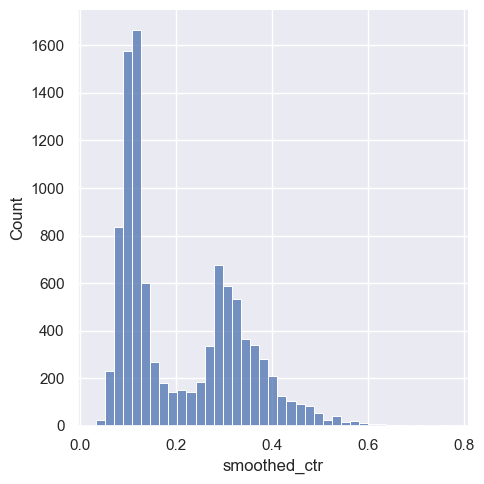

In [100]:
group2 = df[df.exp_group == 2].copy()
group2['smoothed_ctr'] = df.apply(
    lambda x: get_smothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)

sns.displot(group2.smoothed_ctr, 
              kde = False)

**Diagram 3.2  🠉**  <a id='diagram_3_2'></a>

The smoothed CTR distribution looks like the same as withou the smooting.

In [51]:
stats.ttest_ind(group1.smoothed_ctr,
               group2.smoothed_ctr,
               equal_var=False)

Ttest_indResult(statistic=1.5383624332636343, pvalue=0.12398006885092346)

The result is the same as for the non-smoothed CTR.  
A p-value is more than 0.05, meaning the null hypothesis is true.   
**There is no statistically significant difference between the smoothed CTRs of these two groups**
___

# 4. Poisson bootstrap

In [52]:
# define the Poisson bootstrap function
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

<AxesSubplot:ylabel='Count'>

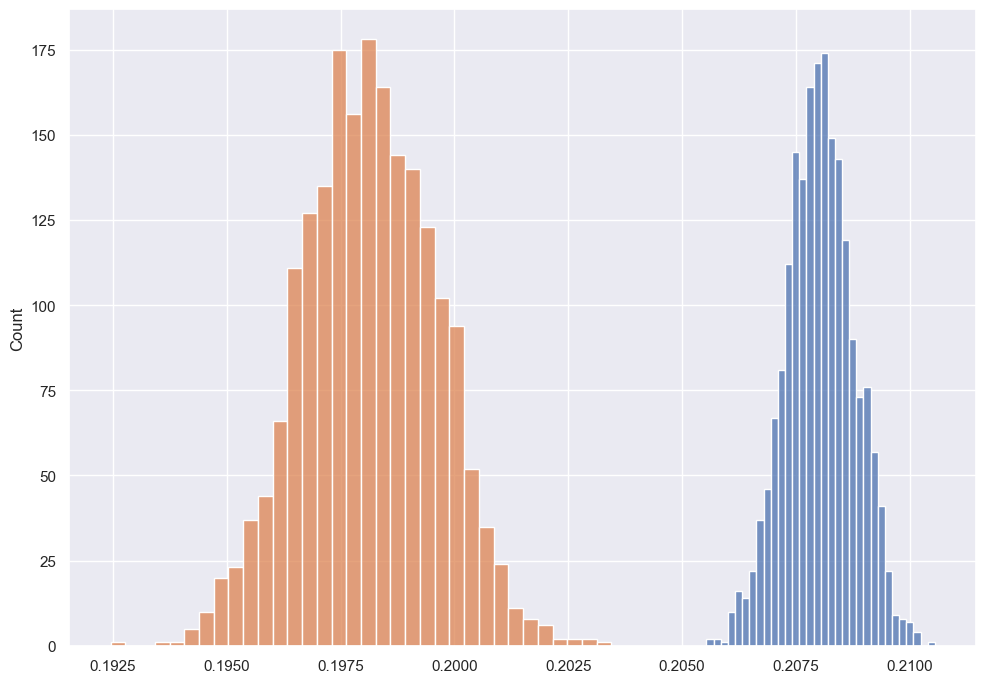

In [55]:
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()

ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.histplot(ctr1)
sns.histplot(ctr2)

**Diagram 4.1  🠉** <a id='diagram_4_1'></a>

<AxesSubplot:ylabel='Count'>

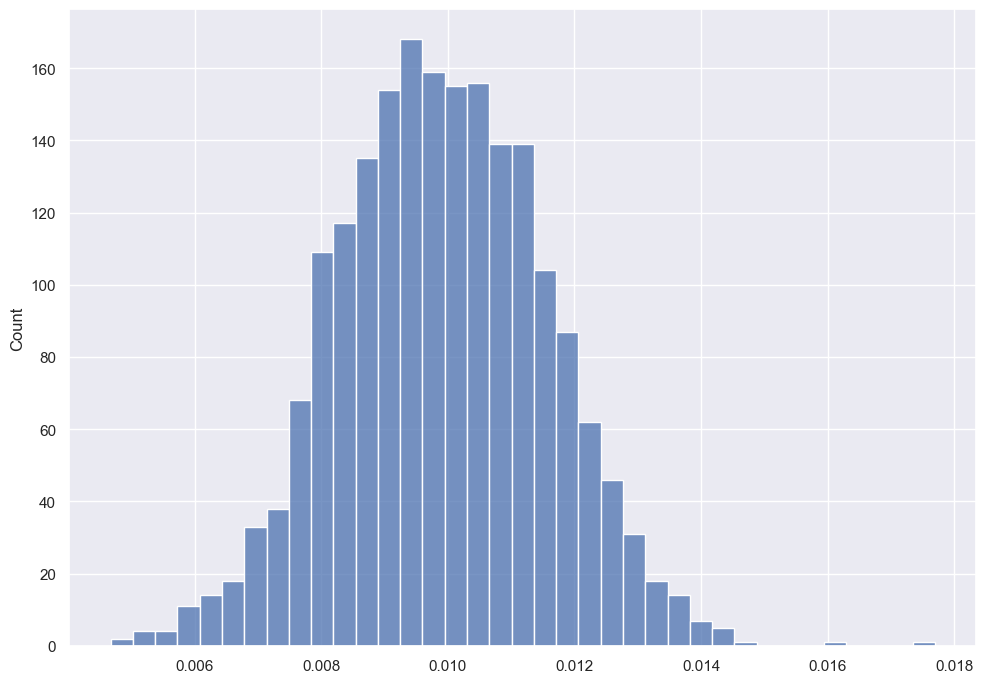

In [57]:
# Difference between global CTRs

sns.histplot(ctr1 - ctr2)

**Diagram 4.2  🠉** <a id='diagram_4_2'></a>

We can see that the distributions of CTRs are not crossing (see diagram 4.1). That means that **according to that method there is a difference between two samples.**  
Also, on the diagram 4.2 (difference between global CTRs) one can see that the distribution is not crossing zero. That is also the sign of difference between two CTR groups.
___

# 5. t-test over bucket

In [70]:
# recieving the data from db
q = """
SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20230120.feed_actions
    WHERE toDate(time) between '2023-01-01' and '2023-01-07'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df = pandahouse.read_clickhouse(q, connection=connection)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

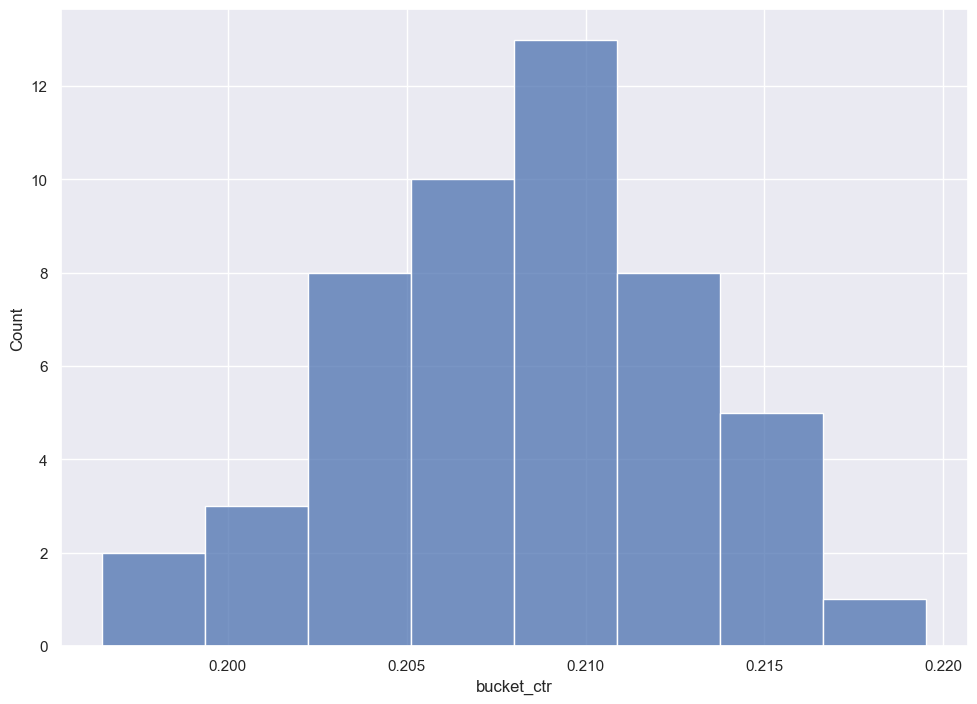

In [78]:
sns.histplot(df[df.exp_group == 1].bucket_ctr)

<AxesSubplot:xlabel='bucket_ctr', ylabel='Count'>

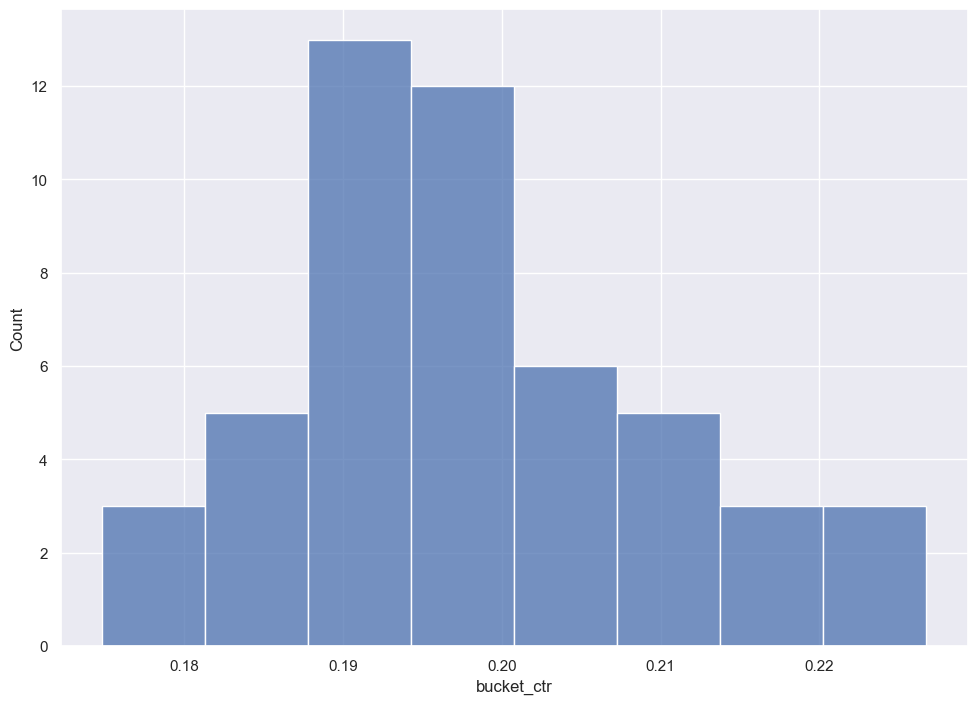

In [77]:
sns.histplot(df[df.exp_group == 2].bucket_ctr)

In [79]:
# t-test over bucket 
stats.ttest_ind(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

p-value is less than 0.05. That means that **t-test over bucket shows that there is a statistically significant difference between CTR mean of these two groups.**

# 6. Mann-Whitney over bucket

In [81]:
stats.mannwhitneyu(df[df.exp_group == 1].bucket_ctr, 
                   df[df.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

p-value is less than 0.05. That means that **Mann Whitney over bucket shows that there is a statistically significant difference between CTR distributions of these two groups.**

# 7. Summary

Below is the summary table of test results:

| Test                           | Comparison objects | Different? |
|--------------------------------|--------------------|------------|
| t-test                         | CTR means          | False      |
| Mann–Whitney U test            | distribution       | True       |
| Poisson bootstrap              | CTR means          | True       |
| T-test with smoothed CTR (α=5) | CTR means          | False      |
| T-test over bucket             | CTR means          | True       |
| Mann–Whitney over bucket       | distribution       | True       |

First of all, from Diagrams [3.1](#diagram_3_1) and [3.2](#diagram_3_2), we can see that there is a difference between of CTR distribution in the groups. Group 1 has a normal unimodal distribution, but group 2 has a bimodal distribution.  
The reasons for bimodal distribution could be next:
* not correct splitting (AA test is done in [Appendix A](appendix_a)). The results show that the split is correct. But I repeated the AA test several times, and in some cases, it showed an error above 5% which could mean that the split is not 100% correct or there needs more data.
* two different samples are mixed into group 2 (not confirmed by AA test in [Appendix A](appendix_a))
* the new algorithm created two groups (A & B) inside the test group. For group A, the CTR decreased; for group B, CTR increased, but the mean CTR was the same (that is confirmed by T-test).

# Conclusions

The results look messy; some t-tests show the difference in mean CTRs, and others do not.  
Mann-Whitney test shows that the distribution is different, but that is obvious if one looks at the diagrams of CTR distributions. It seems like that for some users new algorithm increased CTR, and for others decreased it. 
Poisson bootstrap shows a difference between the average CTRs. Since the bootstrap is the simulation of the "general population", it could mean that there is a real difference between average CTRs, but we do not have enough data to access it correctly.

# Recommendations

In such an unclear situation, I would not recommend implementing the algorithm which was used for group 2 in AB-test. 

However, the data could be used to investigate the groups inside group 2 to identify if there is any correlation between the people for which CTR increased/decreased. For example, for people younger than 30, the new algorithm increases CTR, but for those older than 30, vice versa.
And if this hypothesis is confirmed, the new algorithm could be implemented for the corresponding group.

___

## Appendix A - AA test <a id='appendix_a'></a>

In [102]:
#send the query and save the result to dataframe
q = """
SELECT user_id,
        countIf(action, action = 'view') AS views,
        countIf(action, action = 'like') AS likes,
        likes/views AS ctr,
        any(exp_group) AS exp_group
FROM simulator_20230120.feed_actions
WHERE toDate(time) >= '2022-12-25' 
AND toDate(time) <= '2022-12-31'
GROUP BY user_id
"""

df = pandahouse.read_clickhouse(q, connection=connection)

In [103]:
#number of AA-tests
n = 10000

In [117]:
stat_results = []
p_results = []
for i in range(n):
    A1 = np.random.choice(df[df.exp_group == 2].ctr, 500, replace=False)
    A2 = np.random.choice(df[df.exp_group == 3].ctr, 500, replace=False)
    [statistic, p_value] = stats.ttest_ind(A1, A2, equal_var=False)
    stat_results.append(statistic)
    p_results.append(p_value)

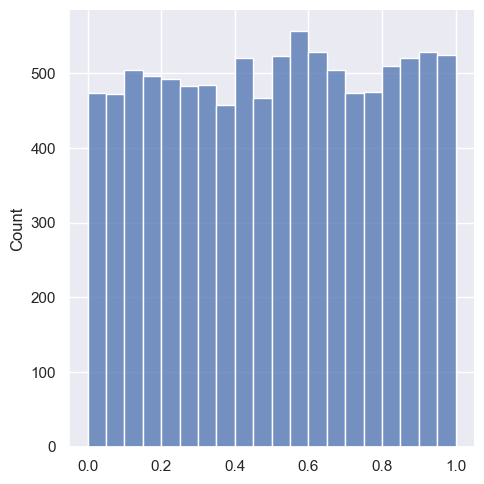

In [118]:
sns.displot(p_results, binwidth=0.05)

In [119]:
# the percentage of p-values less or equal to 0.05
round(((np.array(p_results) <= 0.05).sum() / len(p_results) * 100), 2)

4.74